In [69]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.distributions.kl import kl_divergence

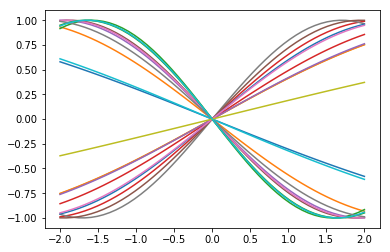

In [70]:
def f(x, alpha):
    return np.sin(alpha*x)

#data generator - 
num_curves = 2000
points_per_curve = 50
x_range = [-2, 2]
alpha_range = [-1, 1]

data = []
xspace = torch.linspace(x_range[0], x_range[1], points_per_curve)
for i in range(num_curves):
    alpha = np.random.uniform(alpha_range[0], alpha_range[1])
    data.append([xspace, f(xspace, alpha)])

num_plots = 20
for i in range(num_plots):
    function = data[i]
    plt.plot(function[0].numpy(), function[1].numpy())
    
def test_f(x):
    return np.sin(x)

testspace = torch.linspace(-2, 2, 4)
test_data = [testspace, test_f(testspace)]

In [71]:
class encoder(nn.Module):
    def __init__(self, output_sizes):
        super(encoder, self).__init__()
        self.output_sizes = output_sizes
        
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3_sigma = nn.Linear(10, self.output_sizes)
        self.fc3_mu = nn.Linear(10, self.output_sizes)
        self.relu = nn.ReLU()
        
    def forward(self, x, y):
        #x and y are 1xn dimensional torch tensors
        
        xy = torch.cat([x, y], dim=0).transpose(0, 1)
        l1 = self.relu(self.fc1(xy))
        l2 = self.relu(self.fc2(l1))
        logvar = self.fc3_sigma(l2)
        mu = self.fc3_mu(l2)
        sigma = torch.exp(logvar.mul(1/2))
        
        out_mu = torch.mean(mu, dim=0)
        out_sigma = torch.mean(sigma, dim=0)
        return out_mu.reshape(self.output_sizes, 1), out_sigma.reshape(self.output_sizes, 1), torch.distributions.Normal(out_mu, out_sigma)

In [72]:
class decoder(nn.Module):
    def __init__(self, encoded_size):
        super(decoder, self).__init__()
        self.encoded_size = encoded_size
        
        self.fc1 = nn.Linear(self.encoded_size + 1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc21 = nn.Linear(10, 10)
        self.fc3_mu = nn.Linear(10, 1)
        self.fc3_sigma = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        
    def forward(self, z, x):
        #x and z are 1xn dimensional torch tensors
        
        zmulti = torch.cat([z for i in range(x.size()[1])], dim=1)
        xz = torch.cat([x, zmulti]).transpose(0, 1)
        
        l1 = self.relu(self.fc1(xz))
        l2 = self.relu(self.fc2(l1))
        l21 = self.relu(self.fc21(l2))
        out_mu = self.fc3_mu(l21)
        out_logvar = self.fc3_sigma(l21)
        out_sigma = torch.exp(out_logvar.mul(1/2))
        
        dist = torch.distributions.Normal(out_mu, out_sigma)
        
        return out_mu, out_sigma, dist

In [73]:
class CNP(nn.Module):
    def __init__(self, encoded_size):
        super(CNP, self).__init__()
        self.encoded_size = encoded_size
        self._encoder = encoder(encoded_size)
        self._decoder = decoder(encoded_size)
        
    def forward(self, context_x, context_y, target_x, target_y=None):
        en_mu, en_sigma, en_dist = self._encoder(context_x, context_y)
        
        representation = en_dist.rsample().unsqueeze(0).transpose(0, 1)
        mu, sigma, dist = self._decoder(representation, target_x)
        
        if target_y is not None:
            log_p = dist.log_prob(target_y.transpose(0, 1)).sum()
            MSE = (mu - target_y.transpose(0,1)).sum()
        else:
            log_p = None
            MSE = None
        return mu, sigma, log_p, en_dist

In [77]:
cnp = CNP(3)
optimizer = torch.optim.Adam(cnp.parameters(), lr=1e-3)
num_test_maximum = 40
plot_frequency = 1
alpha = torch.tensor(1)

def compute_kernel(x, y):
    return (-(x - y).pow(2)).exp()

def MMD(z_prior, z_posterior, num_samples):
    target_samples_1 = z_prior.sample((num_samples,))
    context_samples_1 = z_posterior.sample((num_samples,))
    target_samples_2 = z_prior.sample((num_samples,))
    context_samples_2 = z_posterior.sample((num_samples,))
    
    t_kernel = compute_kernel(target_samples_1, target_samples_2)
    c_kernel = compute_kernel(context_samples_1, context_samples_2)
    ct_kernel = compute_kernel(target_samples_1, context_samples_1) + compute_kernel(target_samples_2, context_samples_2)
    return (t_kernel + c_kernel - ct_kernel).mean()
    

def lossf(log_p, z_prior, z_posterior, alpha):
    KL =  MMD(z_prior, z_posterior, 10).prod()
    return -log_p + alpha*KL


def train(data, cnp, epochs, test_data):
    for epoch in range(epochs):
        total_loss = 0
        iteration = 0
        for function in data:
            optimizer.zero_grad()
            num_points = function[0].size()[0]
            perm = torch.randperm(num_points)
            num_context = np.random.randint(num_points - num_test_maximum, num_points)
            context_x = function[0][perm][0:num_context].unsqueeze(0)
            context_y = function[1][perm][0:num_context].unsqueeze(0)
            test_x = function[0][perm][num_context:num_points].unsqueeze(0)
            test_y = function[1][perm][num_context:num_points].unsqueeze(0)
            
            mu, sigma, log_p, en_dist = cnp(context_x, context_y, test_x, test_y)
            loss = lossf(log_p, torch.distributions.Normal(torch.zeros(cnp.encoded_size), 1), en_dist, alpha)
            loss.backward()
            optimizer.step()
            
            total_loss += loss
            iteration += 1
            
            if iteration % 200 == 0:
                print(iteration)
        
        if epoch % plot_frequency == 0:
            print("EPOCH: {}, LOSS {}".format(epoch, total_loss))
            test_x = test_data[0].unsqueeze(0)
            test_y = test_data[1].unsqueeze(0)
            
            linspace = torch.linspace(-2, 2, 100).unsqueeze(0)
            mu, sigma, _, _ = cnp(test_x, test_y, linspace)
            lin = (linspace.numpy()[0])
            low = np.array((mu-sigma).detach().numpy().T[0])
            high = np.array((mu+sigma).detach().numpy().T[0])
            plt.plot(linspace.numpy()[0], mu.detach().numpy())
            plt.fill_between(lin, low, high, facecolor='#65c9f7', interpolate=True)
            plt.scatter(test_x.numpy(), test_y.numpy(), c='black')
            plt.show()
            
            plt.plot(linspace.numpy()[0], sigma.detach().numpy())
            plt.show()

            
def plot_priors(np, number):
    norm = torch.distributions.Normal(torch.zeros(np.encoded_size), 1)
    for i in range(number):
        z = norm.rsample().unsqueeze(0).transpose(0, 1)
        lin = torch.linspace(-2, 2, 100).unsqueeze(0)
        ys, _, _ = np._decoder(z, lin)
        yplot = ys.transpose(0,1).squeeze(0).detach().numpy()
        xplot = lin.squeeze(0).numpy()
        plt.plot(xplot, yplot)

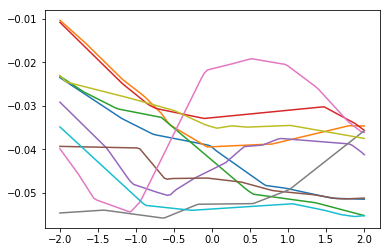

In [78]:
plot_priors(cnp, 10)

200
400
600
800
1000
1200
1400
1600
1800
2000
EPOCH: 0, LOSS 30594.0078125


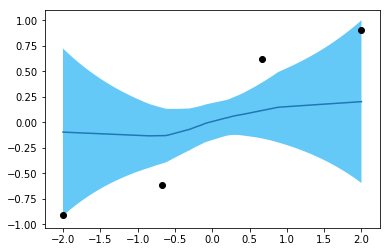

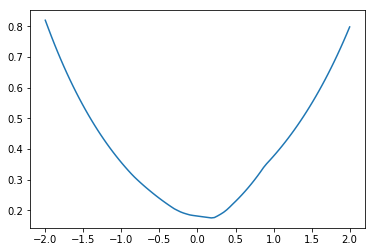

200
400
600
800
1000
1200
1400
1600
1800
2000
EPOCH: 1, LOSS -13984.33203125


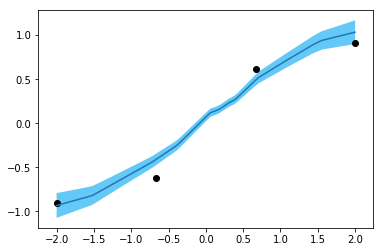

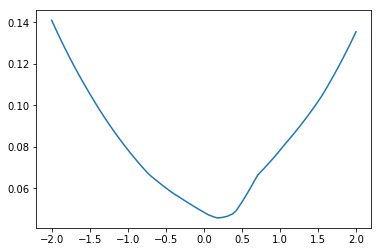

200
400
600
800
1000
1200
1400
1600
1800
2000
EPOCH: 2, LOSS -41741.171875


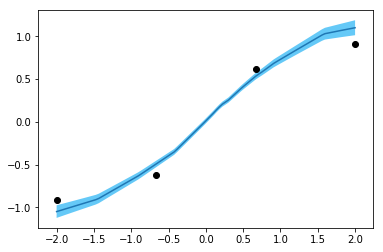

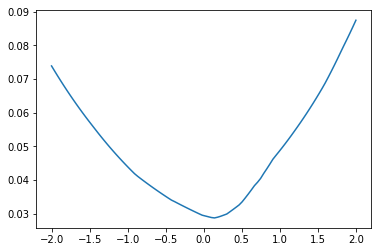

200
400
600
800


KeyboardInterrupt: 

In [79]:
train(data, cnp, 30, test_data)

In [ ]:
plot_priors(cnp, 10)